In [1]:
from heapq import heappop, heappush
from typing import Tuple

import geopandas as gpd
import japanize_matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd
import polars as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import statsmodels.api as sm
from keplergl import KeplerGl
from numpy.linalg import inv
from pypolyagamma import PyPolyaGamma
from pyproj import Transformer
from scipy.stats import multivariate_normal
from shapely import wkt
from shapely.geometry import Point, Polygon
from tqdm import tqdm

from bayesian_statistics.utils_2 import *

/Users/aruohta/dev/bayesian_statistics/.venv/lib/python3.9/site-packages/keplergl/keplergl.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
df_obsidian = pl.read_csv("../data/9_obsidian_gdf.csv", schema_overrides={"No.": str})
df_elevation = pl.read_csv("../data/10_2_gdf_elevation_with_costs.csv")

In [3]:
df_obsidian

No.,遺跡名,緯度,経度,メッシュコード,都道府県,時期名,時期,高原山,和田峠,男女倉,諏訪,蓼科,神津島,箱根,天城,その他(地名),その他,不明,合計,備考,geometry
str,str,f64,f64,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,str,str
"""28""","""白井十二""",36.52221,139.020242,1028.0,"""群馬""","""草創期""","""1""",0.0,92.0,0.0,26.0,0.0,1.0,0.0,0.0,null,0.0,4.0,123.0,"""遺構外""","""POINT (139.02024162782217 36.5…"
"""28""","""白井十二""",36.52221,139.020242,1028.0,"""群馬""","""草創期後半""","""1""",0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,14.0,null,"""POINT (139.02024162782217 36.5…"
"""79""","""原口""",35.349247,139.281171,3079.0,"""神奈川""","""草創期""","""1""",0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,null,0.0,0.0,8.0,null,"""POINT (139.28117094966106 35.3…"
"""99""","""宮ノ前南""",35.403323,139.277256,3099.0,"""神奈川""","""草創期(隆起線文〜爪形文)""","""1""",0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,null,0.0,17.0,56.0,null,"""POINT (139.2772556554631 35.40…"
"""105""","""用田鳥居前""",35.405041,139.415537,3105.0,"""神奈川""","""草創期""","""1""",0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,null,0.0,0.0,2.0,null,"""POINT (139.415537116322 35.405…"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""弥9""","""田原""",34.380531,139.260113,0.0,"""東京""","""晩期〜弥生中期前葉""","""20""",0.0,0.0,0.0,0.0,0.0,180.0,0.0,0.0,null,0.0,0.0,180.0,null,"""POINT (139.2601127256359 34.38…"
"""34""","""落川・一の宮""",35.652486,139.439205,4034.0,"""東京""","""晩期末葉""","""20""",0.0,0.0,0.0,47.0,0.0,0.0,0.0,2.0,null,0.0,5.0,54.0,null,"""POINT (139.43920479611725 35.6…"
"""57""","""下高洞""",34.724485,139.353879,4057.0,"""東京""","""晩期末葉""","""20""",0.0,0.0,0.0,0.0,0.0,139.0,0.0,12.0,null,0.0,9.0,160.0,null,"""POINT (139.35387862440336 34.7…"


In [4]:
df_elevation

grid_x,x,grid_y,y,mesh_code_5th,average_elevation,maximum_elevation,minimum_elevation,minimum_elevation_code,maximum_slope_angle,maximum_slope_direction,minimum_slope_angle,minimum_slope_direction,average_slope_angle,geometry,is_sea,walking_velocity,travel_time,elevation_diff_east,angle_east,walking_velocity_east,travel_time_east,elevation_diff_west,angle_west,walking_velocity_west,travel_time_west,elevation_diff_north,angle_north,walking_velocity_north,travel_time_north,elevation_diff_south,angle_south,walking_velocity_south,travel_time_south,cost_kouzu,cost_shinshu,cost_hakone,cost_takahara,cost_river
i64,f64,i64,f64,str,str,str,str,str,str,str,str,str,str,str,bool,f64,f64,str,str,f64,f64,str,str,f64,f64,str,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64
0,138.001563,0,34.042708,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656,1802.795286,5316.893071,3314.682118,7153.033631,1144.879036
0,138.001563,1,34.044792,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656,1798.93893,5313.036715,3310.825763,7149.177275,1141.022681
0,138.001563,2,34.046875,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656,1795.082575,5309.18036,3306.969407,7145.32092,1137.166325
0,138.001563,3,34.048958,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656,1791.226219,5305.324005,3303.113052,7141.464564,1133.30997
0,138.001563,4,34.051042,null,null,null,null,null,null,null,null,null,null,null,true,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656,1787.369864,5301.467649,3299.256696,7137.608209,1129.453614
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
955,140.985938,1415,36.990625,"""5540378844""",null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",false,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656,6587.928596,5039.74298,4923.01071,2538.782074,20.742865
955,140.985938,1416,36.992708,"""5540379822""",null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",false,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656,6590.991175,5042.805559,4926.073289,2541.844653,23.805445
955,140.985938,1417,36.994792,"""5540379824""",null,null,null,"""nan""",null,"""nan""",null,"""nan""",null,"""POLYGON ((140.98437500001108 3…",false,4.0,3.856355,null,null,4.0,4.246055,null,null,4.0,4.246055,null,null,4.0,3.466656,null,null,4.0,3.466656,6594.84753,5046.661915,4929.929645,2545.701009,27.6618


In [5]:
time_period_dict = {
    "早期末〜前期初頭": 0,
    "後期中葉〜後葉": 3,
    "中期末葉〜後期初頭": 2,
    "早期〜後期": 0,
    "中期後葉〜後期初頭": 2,
    "中期中葉": 2,
    "前期後葉〜中期前葉": 1,
    "早期末": 0,
    "晩期中葉": 4,
    "後期中葉〜晩期前葉": 3,
    "早期〜晩期": 2,  # 例外的に中期
    "中期前葉〜後葉": 2,
    "中期後葉主体": 2,
    "後期末〜晩期": 3,
    "後期前葉〜中葉": 3,
    "晩期終末〜弥生前期末": 4,
    "晩期前葉": 4,
    "前期末葉〜中期初頭": 1,
    "中期初頭": 2,
    "早期": 0,
    "早期中葉〜後葉": 0,
    "後期後葉〜晩期前葉": 3,
    "後期前葉": 3,
    "前期中葉": 1,
    "後期〜晩期": 3,
    "後期前葉〜晩期前葉": 3,
    "早期後葉": 0,
    "後期中葉〜晩期中葉": 3,
    "中期前葉": 2,
    "晩期": 4,
    "前期中葉〜後葉": 1,
    "早期前葉": 0,
    "後期初頭": 3,
    "中期後葉": 2,
    "後期後葉〜晩期初頭": 3,
    "中期後葉〜後期前葉": 2,
    "晩期前葉〜中葉": 4,
    "後期中葉〜晩期初頭": 3,
    "早期中葉": 0,
    "中期後葉〜中期末葉": 2,
    "草創期": 0,
    "前期後葉": 1,
    "後期後葉": 3,
    "中期": 2,
    "後期初頭〜前葉": 3,
    "中期中葉〜後葉": 2,
    "後期中葉": 3,
    "晩期末葉": 4,
    "前期": 1,
    "晩期〜弥生中期前葉": 4,
    "草創期〜早期前葉": 0,
    "前期末葉": 1,
    "前期末葉〜中期前葉": 1,
    "中期初頭〜前葉": 2,
    "後期中葉〜後期後葉": 3,
    "中期前葉〜中葉": 2,
    "前期前葉": 1,
    "後期初頭〜後葉": 3,
    "後期初頭〜後期前葉": 3,
    "早期後葉〜末葉": 0,
    "草創期後半": 0,
    "早期末葉": 0,
    "前期初頭": 1,
}

time_period_name = {0: "早期・早々期", 1: "前期", 2: "中期", 3: "後期", 4: "晩期"}

origin_order = ["神津島", "信州", "箱根", "高原山", "その他"]

# 産地のカラム名と、産地のカテゴリーの定義
origin_columns = [
    "高原山",
    "和田峠",
    "男女倉",
    "諏訪",
    "蓼科",
    "神津島",
    "箱根",
    "天城",
    "その他",
    "不明",
]

origin_dict = {
    "高原山": "高原山",
    "和田峠": "信州",
    "男女倉": "信州",
    "諏訪": "信州",
    "蓼科": "信州",
    "神津島": "神津島",
    "箱根": "箱根",
    "天城": "箱根",
    "その他": "その他",
    "不明": "その他",
}

In [6]:
# "時期名"カラムのユニークな値を確認

df_obsidian["時期名"].unique()

df_obsidian.select(
    pl.col("時期名").str.split("(").list.get(0)
).unique().to_numpy().squeeze()

array(['前期初頭', '後期初頭〜後期前葉', '後期中葉〜晩期前葉', '早期中葉', '早期末〜前期初頭', '後期中葉〜晩期中葉',
       '後期後葉', '中期初頭', '中期末葉〜後期初頭', '前期中葉', '後期前葉〜晩期前葉', '早期前葉', '後期初頭',
       '早期〜後期', '晩期前葉', '後期前葉〜中葉', '中期後葉〜後期前葉', '早期', '後期前葉', '前期末葉〜中期前葉',
       '前期前葉', '中期後葉', '後期中葉〜後葉', '中期', '晩期〜弥生中期前葉', '中期後葉〜後期初頭',
       '後期後葉〜晩期初頭', '後期〜晩期', '草創期後半', '早期後葉', '前期末葉〜中期初頭', '草創期〜早期前葉',
       '中期初頭〜前葉', '前期中葉〜後葉', '中期後葉〜中期末葉', '前期末葉', '後期初頭〜前葉', '中期後葉主体',
       '中期前葉〜後葉', '早期中葉〜後葉', '前期後葉〜中期前葉', '後期初頭〜後葉', '前期後葉', '早期末葉',
       '早期末', '後期末〜晩期', '前期', '中期中葉', '晩期中葉', '中期前葉〜中葉', '晩期前葉〜中葉',
       '早期〜晩期', '後期後葉〜晩期前葉', '中期前葉', '晩期終末〜弥生前期末', '後期中葉', '後期中葉〜後期後葉',
       '中期中葉〜後葉', '晩期末葉', '晩期', '早期後葉〜末葉', '後期中葉〜晩期初頭', '草創期'],
      dtype=object)

- 時期の分け方
    - 早々期、早期
    - 前期
    - 中期
    - 後期
    - 晩期
        - 晩期は後期とセットでも良い
  - 早期〜晩期(五領ヶ台Ⅱ〜阿玉台前半主体)は中期〜前期→中期
  - 早期〜後期(条痕文系が6割程度)は早期〜早期後葉→早期

In [7]:
# No.カラムのうち、int型に変換できない値を確認
max_num = (
    df_obsidian.filter(pl.col("No.") != "弥9")
    .select(pl.col("No.").cast(pl.Int64))
    .max()
    .to_numpy()
    .squeeze()
    .item()
)

df_obsidian = df_obsidian.with_columns(
    [
        (
            pl.col("時期名")
            .str.split("(")
            .list.get(0)
            .replace(time_period_dict)
            .cast(pl.Int64)
            .alias("時期")
        ),
        (pl.col("No.").replace({"弥9": max_num + 1}).cast(pl.Int64).alias("No.")),
    ]
)

# 黒曜石ごとのdfを作成


def expand_obsidian_data(df):
    # 産地のカラムを定義

    # 産地以外のカラムを特定
    other_columns = [
        col for col in df.columns if col not in origin_columns + ["その他(地名)"]
    ]

    # 変換実行
    long_df = df.melt(
        id_vars=other_columns,  # 産地以外のカラムはそのまま保持
        value_vars=origin_columns,  # 産地のカラムを縦持ちに変換
        variable_name="産地",  # 新しい産地カラムの名前
        value_name="点数",  # 数値を持つカラムの名前
    )

    # 点数が0より大きい行だけを保持
    long_df = long_df.filter(pl.col("点数") > 0)

    # 点数の数だけのリストを作成し、それをexplode
    long_df = long_df.with_columns(
        [
            pl.col("点数")
            .cast(pl.Int64)
            .map_elements(lambda x: [1] * x)
            .alias("points_list")
        ]
    )

    # リストをexplodeして各行を複製
    result = long_df.explode("points_list")

    # 不要なカラムを削除
    result = result.drop(["点数", "points_list"])

    return result


# 産地以外のカラムを特定
other_columns = [
    col for col in df_obsidian.columns if col not in origin_columns + ["その他(地名)"]
]

df_result = (
    df_obsidian.unpivot(
        index=other_columns,  # 産地以外のカラムはそのまま保持
        on=origin_columns,  # 産地のカラムを縦持ちに変換
        variable_name="産地",  # 新しい産地カラムの名前
        value_name="点数",  # 数値を持つカラムの名前
    )
    .filter(pl.col("点数") > 0)
    .with_columns(
        [
            pl.col("点数")
            .cast(pl.Int64)
            .map_elements(lambda x: [1] * x, return_dtype=list)
            .alias("points_list")
        ]
    )
    .explode("points_list")
    .drop(["点数", "points_list"])
    .with_columns([pl.col("産地").replace(origin_dict).alias("産地カテゴリ")])
)

# 遺跡の位置
df_sites = (
    df_result.group_by(["遺跡名", "緯度", "経度"])
    .first()
    .drop(["No.", "時期名", "時期", "産地", "産地カテゴリ", "合計", "備考"])
    .sort(pl.col("経度"), pl.col("緯度"), pl.col("遺跡名"))
    # 遺跡にIDを割り振る
    .with_row_index()
    .with_columns([pl.col("index").cast(pl.Int64).alias("遺跡ID")])
    .drop("index")
)

#

# 遺跡IDをdf_resultに戻す
df_result = df_result.join(
    df_sites.drop(["メッシュコード", "都道府県", "geometry"]),
    on=["遺跡名", "緯度", "経度"],
).drop(["No.", "遺跡名", "メッシュコード", "都道府県", "合計"])

### 遺跡のデータに5次メッシュを付与する

In [8]:
def create_meshcode_expr(lat_col: str, lon_col: str, level: int = 6) -> pl.Expr:
    """
    緯度経度からメッシュコードを生成する式を作成

    Args:
        lat_col: 緯度のカラム名
        lon_col: 経度のカラム名
        level: メッシュコードの精度レベル

    Returns:
        pl.Expr: メッシュコードを生成する式
    """

    def split_decimal(col: pl.Expr) -> tuple[pl.Expr, pl.Expr]:
        """少数部分と整数部分を分離"""
        int_part = col.cast(pl.Int64)
        decimal_part = col - int_part
        return int_part, decimal_part

    # 緯度の計算(80km->10km->1km->500m->250m->125m)
    lat = pl.col(lat_col)
    lat_80km, lat_dec_80km = split_decimal(lat * 1.5)  # 1次メッシュ(80km)
    lat_10km, lat_dec_10km = split_decimal(lat_dec_80km * 8)  # 2次メッシュ(10km)
    lat_1km, lat_dec_1km = split_decimal(lat_dec_10km * 10)  # 3次メッシュ(1km)
    lat_500m, lat_dec_500m = split_decimal(lat_dec_1km * 2)  # 4次メッシュ(500m)
    lat_250m, lat_dec_250m = split_decimal(lat_dec_500m * 2)  # 5次メッシュ(250m)
    lat_125m, _ = split_decimal(lat_dec_250m * 2)  # 6次メッシュ(125m)

    # 経度の計算(80km->10km->1km->500m->250m->125m)
    lon = pl.col(lon_col)
    lon_80km, lon_dec_80km = split_decimal(lon - 100)  # 1次メッシュ(80km)
    lon_10km, lon_dec_10km = split_decimal(lon_dec_80km * 8)  # 2次メッシュ(10km)
    lon_1km, lon_dec_1km = split_decimal(lon_dec_10km * 10)  # 3次メッシュ(1km)
    lon_500m, lon_dec_500m = split_decimal(lon_dec_1km * 2)  # 4次メッシュ(500m)
    lon_250m, lon_dec_250m = split_decimal(lon_dec_500m * 2)  # 5次メッシュ(250m)
    lon_125m, _ = split_decimal(lon_dec_250m * 2)  # 6次メッシュ(125m)

    # メッシュコードの組み立て
    # 1次メッシュ(80km)
    mesh_code = (lat_80km * 100 + lon_80km).cast(pl.Int64).cast(pl.Utf8)

    if level >= 2:
        # 2次メッシュ(10km)
        mesh_code = pl.concat_str(
            [
                mesh_code,
                lat_10km.abs().cast(pl.Int64).cast(pl.Utf8),
                lon_10km.abs().cast(pl.Int64).cast(pl.Utf8),
            ]
        )

    if level >= 3:
        # 3次メッシュ(1km)
        mesh_code = pl.concat_str(
            [
                mesh_code,
                lat_1km.abs().cast(pl.Int64).cast(pl.Utf8),
                lon_1km.abs().cast(pl.Int64).cast(pl.Utf8),
            ]
        )

    if level >= 4:
        # 4次メッシュ(500m), str([0 or 1]*2 + [1-2]) -> [01, 02, 11, 12]
        mesh_code = pl.concat_str(
            [
                mesh_code,
                (lat_500m * 2 + lon_500m + 1).cast(pl.Int64).cast(pl.Utf8),
            ]
        )

    if level >= 5:
        # 5次メッシュ(250m), str([0 or 1]*2 + [1-2]) -> [01, 02, 11, 12]
        mesh_code = pl.concat_str(
            [
                mesh_code,
                (lat_250m * 2 + lon_250m + 1).cast(pl.Int64).cast(pl.Utf8),
            ]
        )

    if level >= 6:
        # 6次メッシュ(125m), str([0 or 1]*2 + [1-2]) -> [01, 02, 11, 12]
        mesh_code = pl.concat_str(
            [
                mesh_code,
                (lat_125m * 2 + lon_125m + 1).cast(pl.Int64).cast(pl.Utf8),
            ]
        )

    return mesh_code.cast(pl.Int64)


# 使用例
def add_meshcode(
    df: pl.DataFrame,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
    level: int = 6,
    output_col: str = "meshcode",
) -> pl.DataFrame:
    """
    DataFrameにメッシュコードカラムを追加

    Args:
        df: 入力DataFrame
        lat_col: 緯度のカラム名
        lon_col: 経度のカラム名
        level: メッシュコードのレベル
        output_col: 出力カラム名

    Returns:
        pl.DataFrame: メッシュコード付きDataFrame
    """
    return df.with_columns(
        [create_meshcode_expr(lat_col, lon_col, level).alias(output_col)]
    )


# LazyFrame用の関数
def add_meshcode_lazy(
    lf: pl.LazyFrame,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
    level: int = 6,
    output_col: str = "meshcode",
) -> pl.LazyFrame:
    """
    LazyFrameにメッシュコードカラムを追加

    Args:
        lf: 入力LazyFrame
        lat_col: 緯度のカラム名
        lon_col: 経度のカラム名
        level: メッシュコードのレベル
        output_col: 出力カラム名

    Returns:
        pl.LazyFrame: メッシュコード付きLazyFrame
    """
    return lf.with_columns(
        [create_meshcode_expr(lat_col, lon_col, level).alias(output_col)]
    )

In [9]:
# df_sitesにメッシュコードを追加
df_sites = df_sites.with_columns(
    [pl.col("メッシュコード").alias("メッシュコード_1st")]
).drop("メッシュコード")
df_sites = add_meshcode(df_sites, "緯度", "経度", 5, "メッシュコード")

### df_sitesに、df_elevationを参照して特徴量を付与

In [10]:
df_sites

遺跡名,緯度,経度,都道府県,geometry,遺跡ID,メッシュコード_1st,メッシュコード
str,f64,f64,str,str,i64,f64,i64
"""暮坪""",36.555566,138.60464,"""群馬""","""POINT (138.6046398287989 36.55…",0,1017.0,5438646832
"""坪井""",36.557583,138.624675,"""群馬""","""POINT (138.62467510054935 36.5…",1,1032.0,5438646944
"""天神原""",36.594127,138.814862,"""群馬""","""POINT (138.8148617429243 36.59…",2,1034.0,5438761513
"""上丹生屋敷山""",36.266281,138.824113,"""群馬""","""POINT (138.82411306547058 36.2…",3,1016.0,5438361544
"""榎木畑""",36.31927,138.850352,"""群馬""","""POINT (138.850351837435 36.319…",4,1010.0,5438368813
…,…,…,…,…,…,…,…
"""上谷津第2""",35.624437,140.251113,"""千葉""","""POINT (140.2511133685772 35.62…",269,5024.0,5340324033
"""八幡脇""",36.081469,140.255307,"""茨城""","""POINT (140.2553070670662 36.08…",270,7010.0,5440029034
"""陸平貝塚""",36.017156,140.347927,"""茨城""","""POINT (140.34792720050785 36.0…",271,7003.0,5440022722


### 平面直角座標形の座標を追加する

In [11]:
def add_meter_coordinates(
    df: pl.DataFrame, lat_col: str, lon_col: str, epsg_to: str = "EPSG:6677"
) -> pl.DataFrame:
    """
    緯度経度からメートル座標に変換してDataFrameに追加

    Args:
        df: 入力DataFrame
        lat_col: 緯度のカラム名
        lon_col: 経度のカラム名
        epsg_to: 変換先のEPSGコード

    Returns:
        pl.DataFrame: メートル座標を追加したDataFrame
    """
    transformer = Transformer.from_crs("EPSG:4326", epsg_to, always_xy=True)

    x_meter, y_meter = transformer.transform(
        df.select(pl.col(lon_col)).to_numpy().squeeze(),
        df.select(pl.col(lat_col)).to_numpy().squeeze(),
    )

    return df.with_columns(
        [pl.Series("x_meter", x_meter), pl.Series("y_meter", y_meter)]
    )

In [12]:
# df_sites, df_result, df_elevationにメートル座標を追加
epsg_to = "EPSG:32654"

df_sites = add_meter_coordinates(df_sites, "緯度", "経度", epsg_to)
df_result = add_meter_coordinates(df_result, "緯度", "経度", epsg_to)
df_elevation = add_meter_coordinates(df_elevation, "y", "x", epsg_to)

# 産地カテゴリ、時期別の、黒曜石の数のヒートマップ

In [13]:
df_result.group_by(["産地カテゴリ", "時期"]).len().pivot(
    on="産地カテゴリ", index="時期", values="len"
).sort("時期").to_pandas().set_index("時期")

,高原山,神津島,信州,箱根,その他
時期,,,,,
0,15,1019,342,90,171
1,20,2471,1690,111,252
2,128,10277,4626,442,1244
3,585,1189,2998,596,578
4,78,400,590,88,70


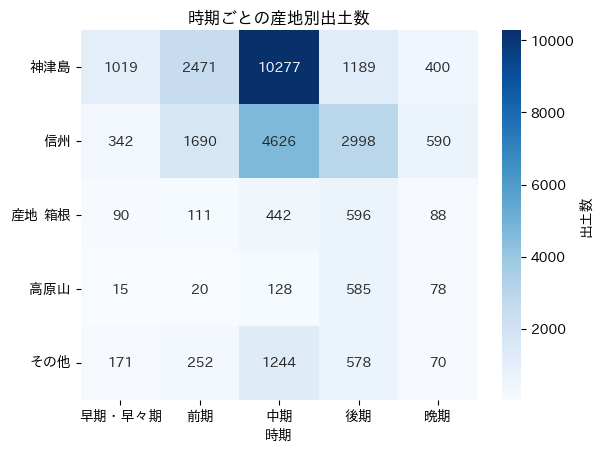

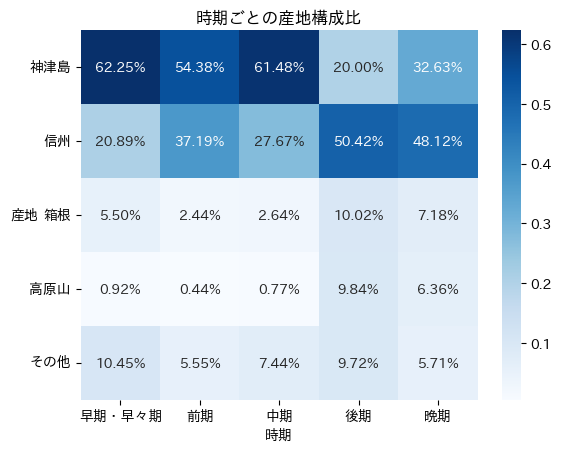

In [14]:
sns.heatmap(
    data=(
        df_result.group_by(["産地カテゴリ", "時期"])
        .len()
        .pivot(on="産地カテゴリ", index="時期", values="len")
        .sort("時期")
        .to_pandas()
        .set_index("時期")
        .rename(index=time_period_name)
        .reindex(columns=origin_order)
        .transpose()
    ),
    cmap="Blues",
    annot=True,
    fmt="d",
    yticklabels=True,
    cbar_kws={"label": "出土数"},
)

# y軸のラベルを水平に設定
plt.yticks(rotation=0)
plt.ylabel("産地", rotation=0, va="center", fontweight="heavy")
plt.xlabel("時期", fontweight="heavy")

plt.title("時期ごとの産地別出土数")
plt.show()

sns.heatmap(
    data=(
        df_result.group_by(["産地カテゴリ", "時期"])
        .len()
        .pivot(on="産地カテゴリ", index="時期", values="len")
        .sort("時期")
        .to_pandas()
        .set_index("時期")
        .rename(index=time_period_name)
        .reindex(columns=origin_order)
        .apply(lambda x: x / x.sum(), axis=1)
        .transpose()
    ),
    cmap="Blues",
    annot=True,
    fmt=".2%",
    yticklabels=True,  # y軸ラベルを表示
)

# y軸のラベルを水平に設定
plt.yticks(rotation=0)
plt.ylabel("産地", rotation=0, va="center", fontweight="heavy")
plt.xlabel("時期", fontweight="heavy")

plt.title("時期ごとの産地構成比")
plt.show()

In [15]:
df_result.write_csv("../data/11_gdf_obsidian.csv")
df_sites.write_csv("../data/11_gdf_sites.csv")
df_elevation.write_csv("../data/11_gdf_elevation.csv")